In [1]:
from os import path 

import anndata
import openTSNE
import scanpy as sc
import numpy as np
import pandas as pd

import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "cao_2019.h5ad"))
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2058652 × 26183 
    obs: 'id', 'sex', 'day', 'Total_mRNAs', 'tsne_1', 'tsne_2', 'cluster_id', 'sub_tsne_1', 'sub_tsne_2', 'Sub_Cluster', 'db_score', 'detected_doublet', 'potential_doublet_cluster'
    var: 'gene_id', 'gene_type'
    uns: 'name', 'organism', 'tissue', 'year'

In [3]:
adata.obs.head()

,id,sex,day,Total_mRNAs,tsne_1,tsne_2,cluster_id,sub_tsne_1,sub_tsne_2,Sub_Cluster,db_score,detected_doublet,potential_doublet_cluster
sample,,,,,,,,,,,,,
sci3-me-001.GTCGGAGTTTGAGGTAGAA,38,F,13.5,335.0,2.502835,2.589219,5.0,0.00000,0.000000,unknown,0.013367,False,nan
sci3-me-001.ATTAGTCTGTGTATAATACG,9,M,11.5,1989.0,19.352971,-5.523709,20.0,4.01933,18.306513,1,0.004160,False,False
sci3-me-001.GAGGAACTTAATACCATCC,26,F,10.5,393.0,-15.372493,-5.759600,21.0,0.00000,0.000000,unknown,0.002524,False,nan
sci3-me-001.TTCGCGGATACTCTCTCAA,16,F,13.5,227.0,-0.750546,1.439024,17.0,0.00000,0.000000,unknown,0.006938,False,nan
sci3-me-001.ACTGGTTATTTGCGCCATCT,33,M,12.5,241.0,2.402283,12.564681,6.0,0.00000,0.000000,unknown,0.002918,False,nan


## Remove doublets

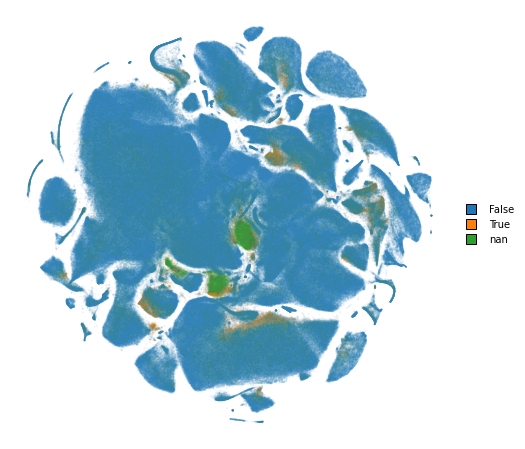

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(adata.obs[["tsne_1", "tsne_2"]].values, adata.obs["detected_doublet"].values,
           s=1, alpha=0.04, draw_legend=True, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")
ax.set_aspect("equal", adjustable="box")

In [5]:
print("Removing %d putative doublets" % np.sum(adata.obs["detected_doublet"] == "nan"))
adata = adata[adata.obs["detected_doublet"] != "nan"]
adata

Removing 32011 putative doublets


View of AnnData object with n_obs × n_vars = 2026641 × 26183 
    obs: 'id', 'sex', 'day', 'Total_mRNAs', 'tsne_1', 'tsne_2', 'cluster_id', 'sub_tsne_1', 'sub_tsne_2', 'Sub_Cluster', 'db_score', 'detected_doublet', 'potential_doublet_cluster'
    var: 'gene_id', 'gene_type'
    uns: 'name', 'organism', 'tissue', 'year'

## Preprocessing

In [6]:
sc.pp.filter_genes(adata, min_counts=10)
adata

Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2026641 × 26180 
    obs: 'id', 'sex', 'day', 'Total_mRNAs', 'tsne_1', 'tsne_2', 'cluster_id', 'sub_tsne_1', 'sub_tsne_2', 'Sub_Cluster', 'db_score', 'detected_doublet', 'potential_doublet_cluster'
    var: 'gene_id', 'gene_type', 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.07
CPU times: user 1min 4s, sys: 39 s, total: 1min 43s
Wall time: 1min 43s


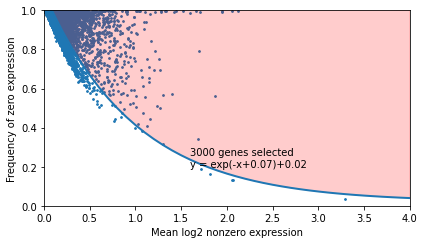

In [7]:
%time gene_mask = utils.select_genes(adata.X, n=3000, threshold=0)

In [8]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
adata.obsm["X_pca"] = utils.pca(adata.X[:, gene_mask])

## Sample embedding

In [10]:
np.random.seed(0)

In [11]:
x, y = adata.obsm["X_pca"], adata.obs["day"]

In [12]:
indices = np.random.permutation(list(range(x.shape[0])))
reverse = np.argsort(indices)

x_sample, x_rest = x[indices[:25000]], x[indices[25000:]]
y_sample, y_rest = y[indices[:25000]], y[indices[25000:]]

### Create sample embedding

In [13]:
%%time
sample_affinities = openTSNE.affinity.PerplexityBasedNN(
    x_sample,
    perplexity=500,
    metric="cosine",
    n_jobs=24,
    random_state=0,
    verbose=True,
)

===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 14.96 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 6.19 seconds
CPU times: user 4min 18s, sys: 2.18 s, total: 4min 20s
Wall time: 21.1 s


In [14]:
%time sample_init = openTSNE.initialization.spectral(sample_affinities.P)

CPU times: user 2min 42s, sys: 10.4 s, total: 2min 53s
Wall time: 7.43 s


In [15]:
sample_embedding = openTSNE.TSNEEmbedding(sample_init, sample_affinities, n_jobs=24, verbose=True)

In [16]:
%time sample_embedding1 = sample_embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

===> Running optimization with exaggeration=12.00, lr=2083.33 for 250 iterations...
Iteration   50, KL divergence 3.1739, 50 iterations in 2.9651 sec
Iteration  100, KL divergence 3.0712, 50 iterations in 2.9350 sec
Iteration  150, KL divergence 3.0692, 50 iterations in 2.7909 sec
Iteration  200, KL divergence 3.0690, 50 iterations in 2.8913 sec
Iteration  250, KL divergence 3.0689, 50 iterations in 2.8837 sec
   --> Time elapsed: 14.47 seconds
CPU times: user 5min 45s, sys: 6.81 s, total: 5min 52s
Wall time: 14.8 s


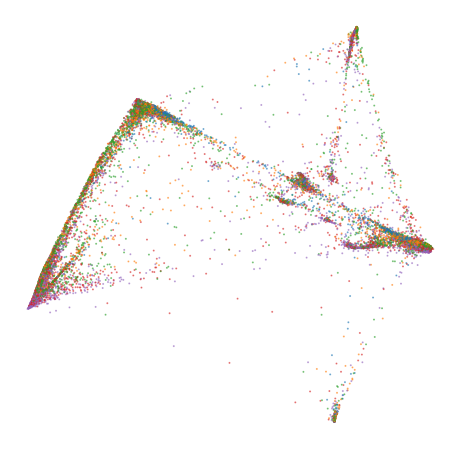

In [17]:
utils.plot(sample_embedding1, y[indices[:25000]], alpha=0.5, draw_legend=False)

In [18]:
%time sample_embedding2 = sample_embedding1.optimize(n_iter=500, exaggeration=1, momentum=0.8)

===> Running optimization with exaggeration=1.00, lr=2083.33 for 500 iterations...
Iteration   50, KL divergence 1.5386, 50 iterations in 3.0955 sec
Iteration  100, KL divergence 1.3392, 50 iterations in 2.8790 sec
Iteration  150, KL divergence 1.2667, 50 iterations in 2.8802 sec
Iteration  200, KL divergence 1.2329, 50 iterations in 3.0010 sec
Iteration  250, KL divergence 1.2150, 50 iterations in 2.9880 sec
Iteration  300, KL divergence 1.2049, 50 iterations in 3.1616 sec
Iteration  350, KL divergence 1.1983, 50 iterations in 3.2186 sec
Iteration  400, KL divergence 1.1943, 50 iterations in 3.4246 sec
Iteration  450, KL divergence 1.1913, 50 iterations in 3.2883 sec
Iteration  500, KL divergence 1.1889, 50 iterations in 3.5232 sec
   --> Time elapsed: 31.46 seconds
CPU times: user 12min 18s, sys: 15.9 s, total: 12min 34s
Wall time: 31.6 s


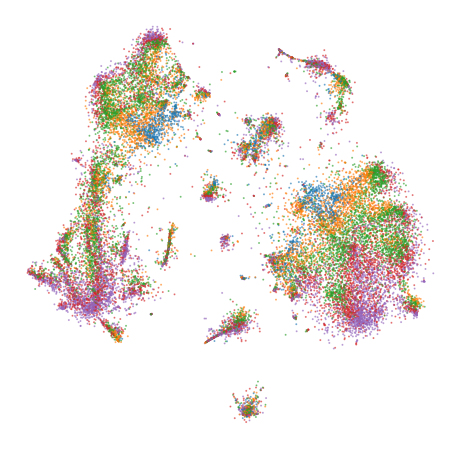

In [19]:
utils.plot(sample_embedding2, y[indices[:25000]], alpha=0.5, draw_legend=False)

## Full embedding

In [20]:
%%time
affinities = openTSNE.affinity.PerplexityBasedNN(
    x,
    perplexity=30,
    metric="cosine",
    n_jobs=24,
    random_state=0,
    verbose=True,
)

===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 711.10 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 51.48 seconds
CPU times: user 53min 24s, sys: 1min 33s, total: 54min 58s
Wall time: 12min 42s


In [21]:
%time rest_init = sample_embedding2.prepare_partial(x_rest, k=1, perplexity=1/3)

===> Finding 1 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 391.66 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.51 seconds
CPU times: user 10min 25s, sys: 56.9 s, total: 11min 22s
Wall time: 6min 33s


In [22]:
init_full = np.vstack((sample_embedding2, rest_init))[reverse]

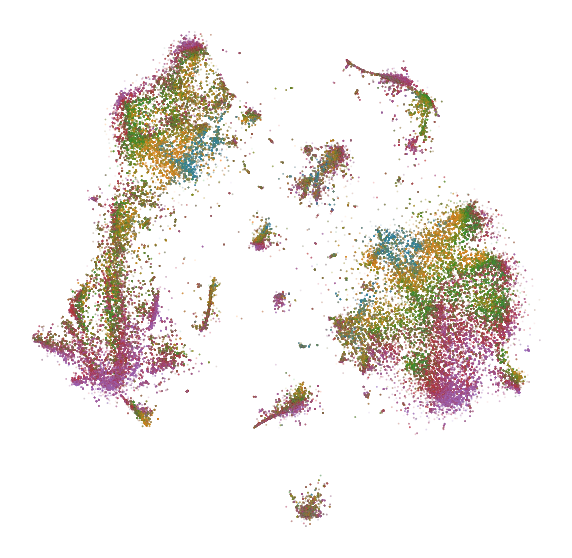

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot(init_full, y, ax=ax, draw_legend=False, s=1, alpha=0.05)

In [24]:
init_full = init_full / (np.std(init_full[:, 0]) * 10000)
np.std(init_full, axis=0)

array([1.00000000e-04, 7.30124708e-05])

In [25]:
embedding = openTSNE.TSNEEmbedding(init_full, affinities, n_jobs=8, random_state=42, verbose=True)

In [26]:
%time embedding1 = embedding.optimize(n_iter=500, exaggeration=12, momentum=0.5)

===> Running optimization with exaggeration=12.00, lr=168886.75 for 500 iterations...
Iteration   50, KL divergence 9.6913, 50 iterations in 120.9117 sec
Iteration  100, KL divergence 9.0279, 50 iterations in 129.0018 sec
Iteration  150, KL divergence 8.8550, 50 iterations in 129.1480 sec
Iteration  200, KL divergence 8.7654, 50 iterations in 128.8478 sec
Iteration  250, KL divergence 8.7085, 50 iterations in 128.0677 sec
Iteration  300, KL divergence 8.6698, 50 iterations in 129.4376 sec
Iteration  350, KL divergence 8.6429, 50 iterations in 131.9314 sec
Iteration  400, KL divergence 8.6226, 50 iterations in 129.0724 sec
Iteration  450, KL divergence 8.6035, 50 iterations in 130.9138 sec
Iteration  500, KL divergence 8.5885, 50 iterations in 128.0926 sec
   --> Time elapsed: 1285.43 seconds
CPU times: user 2h 7min 21s, sys: 1min 44s, total: 2h 9min 5s
Wall time: 21min 31s


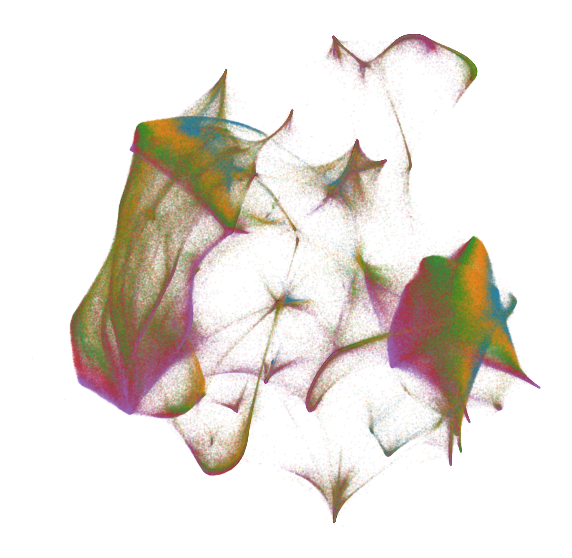

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot(embedding1, y, ax=ax, draw_legend=False, s=1, alpha=0.05)

In [28]:
%time embedding2 = embedding1.optimize(n_iter=500, exaggeration=4, momentum=0.8)

===> Running optimization with exaggeration=4.00, lr=168886.75 for 500 iterations...
Iteration   50, KL divergence 7.7453, 50 iterations in 121.7203 sec
Iteration  100, KL divergence 7.4919, 50 iterations in 122.9322 sec
Iteration  150, KL divergence 7.3748, 50 iterations in 122.2083 sec
Iteration  200, KL divergence 7.3043, 50 iterations in 121.1618 sec
Iteration  250, KL divergence 7.2611, 50 iterations in 120.3997 sec
Iteration  300, KL divergence 7.2289, 50 iterations in 122.4659 sec
Iteration  350, KL divergence 7.2048, 50 iterations in 124.4535 sec
Iteration  400, KL divergence 7.1868, 50 iterations in 124.4842 sec
Iteration  450, KL divergence 7.1727, 50 iterations in 125.1676 sec
Iteration  500, KL divergence 7.1612, 50 iterations in 125.9307 sec
   --> Time elapsed: 1230.93 seconds
CPU times: user 1h 59min 20s, sys: 1min 43s, total: 2h 1min 4s
Wall time: 20min 36s


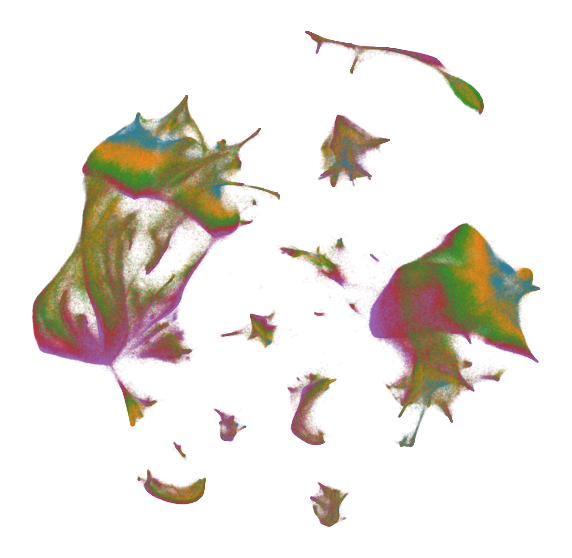

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot(embedding2, y, ax=ax, draw_legend=False, s=1, alpha=0.05)

In [30]:
%time embedding3 = embedding2.optimize(n_iter=500, exaggeration=2, momentum=0.8)

===> Running optimization with exaggeration=2.00, lr=168886.75 for 500 iterations...
Iteration   50, KL divergence 6.7332, 50 iterations in 130.6404 sec
Iteration  100, KL divergence 6.5830, 50 iterations in 131.5322 sec
Iteration  150, KL divergence 6.4747, 50 iterations in 122.4732 sec
Iteration  200, KL divergence 6.3956, 50 iterations in 124.5494 sec
Iteration  250, KL divergence 6.3376, 50 iterations in 123.3893 sec
Iteration  300, KL divergence 6.2925, 50 iterations in 122.2665 sec
Iteration  350, KL divergence 6.2555, 50 iterations in 124.2491 sec
Iteration  400, KL divergence 6.2246, 50 iterations in 131.3549 sec
Iteration  450, KL divergence 6.1986, 50 iterations in 124.5240 sec
Iteration  500, KL divergence 6.1767, 50 iterations in 125.7369 sec
   --> Time elapsed: 1260.72 seconds
CPU times: user 2h 3min 59s, sys: 1min 41s, total: 2h 5min 40s
Wall time: 21min 6s


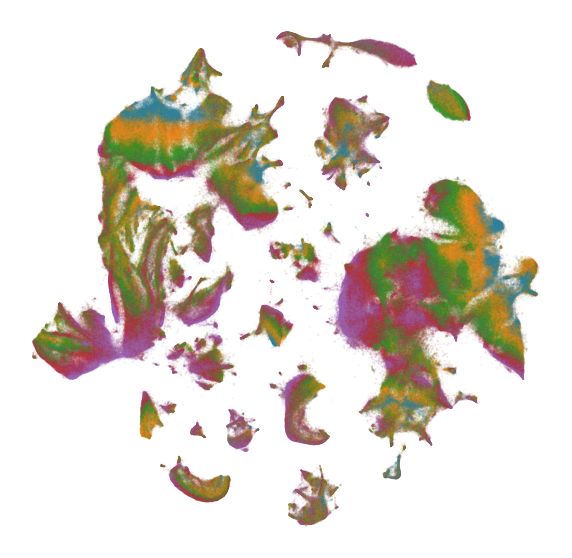

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot(embedding3, y, ax=ax, draw_legend=False, s=1, alpha=0.05)

In [32]:
%time embedding4 = embedding3.optimize(n_iter=500, exaggeration=1, momentum=0.8)

===> Running optimization with exaggeration=1.00, lr=168886.75 for 500 iterations...
Iteration   50, KL divergence 6.0027, 50 iterations in 124.6641 sec
Iteration  100, KL divergence 5.9215, 50 iterations in 122.1616 sec
Iteration  150, KL divergence 5.8433, 50 iterations in 125.0772 sec
Iteration  200, KL divergence 5.7683, 50 iterations in 128.2022 sec
Iteration  250, KL divergence 5.7009, 50 iterations in 132.1685 sec
Iteration  300, KL divergence 5.6419, 50 iterations in 131.5050 sec
Iteration  350, KL divergence 5.5906, 50 iterations in 130.0192 sec
Iteration  400, KL divergence 5.5460, 50 iterations in 131.7017 sec
Iteration  450, KL divergence 5.5070, 50 iterations in 134.9756 sec
Iteration  500, KL divergence 5.4745, 50 iterations in 141.7945 sec
   --> Time elapsed: 1302.27 seconds
CPU times: user 2h 1min 26s, sys: 1min 54s, total: 2h 3min 20s
Wall time: 21min 47s


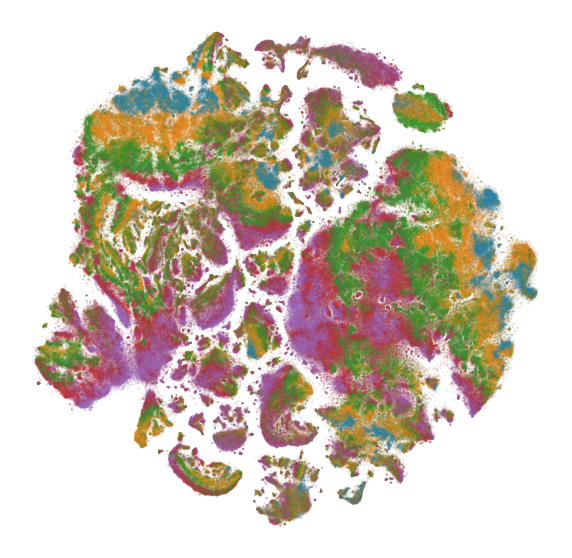

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot(embedding4, y, ax=ax, draw_legend=False, s=1, alpha=0.05)

In [41]:
pd.DataFrame(embedding2, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("cao/exag4.csv")
pd.DataFrame(embedding3, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("cao/exag2.csv")
pd.DataFrame(embedding4, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("cao/exag1.csv")

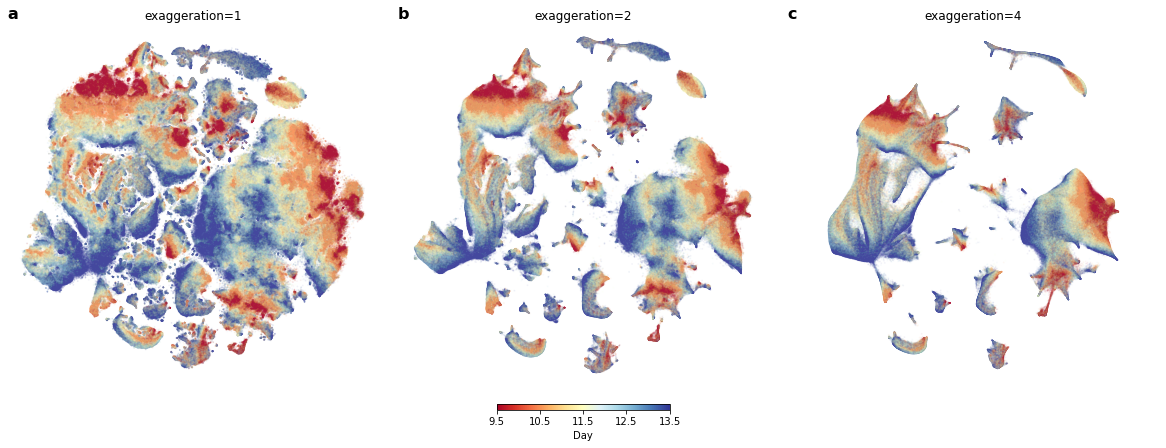

In [42]:
import string

fig, ax = plt.subplots(ncols=3, figsize=(16, 16/3))

#rand_idx = np.random.choice(range(adata.shape[0]), size=(5000), replace=False)
    
for emb, exag, ax_ in zip([embedding4, embedding3, embedding2], [1, 2, 4], ax.ravel()):
    sc = ax_.scatter(emb[:, 0], emb[:, 1], c=adata.obs["day"], cmap="RdYlBu", alpha=0.04, s=1, rasterized=True)
    #sc = ax_.scatter(emb[rand_idx, 0], emb[rand_idx, 1], c=adata.obs["day"][rand_idx],
    #                 cmap="RdYlBu", alpha=1, s=3, rasterized=True)
    ax_.set_xticks([]), ax_.set_yticks([])
    ax_.axis("off")
    ax_.axis("equal")
    ax_.set_title(f"exaggeration={exag}", va="baseline")
    
plt.subplots_adjust(wspace=0.05, hspace=0.05, top=1, bottom=0, left=0, right=1)

for ax_, letter in zip(ax.ravel(), string.ascii_lowercase): 
    plt.text(0, 1.02, letter, transform=ax_.transAxes, fontsize=16, va="baseline", fontweight="bold")
    
color_bar = fig.colorbar(sc, ax=ax.ravel().tolist(), ticks=adata.obs["day"].unique(), label="Day",
                         orientation="horizontal", anchor=(0.5, 0), fraction=0.015, aspect=30, pad=0.05)
color_bar.set_alpha(1)
color_bar.draw_all()

plt.savefig(path.join("..", "figures", "cao2019.pdf"), dpi=300, bbox_inches="tight", transparent=True, width=16, height=16/3)